## CINK calculation (integral / annual sum)

The average annual C-sink factor over a time horizon \(H\) is defined as the sum of the annual integrals of the SPC function divided by \(H\):

$$
\mathrm{CINK}(H)
= \frac{1}{H}\sum_{i=1}^{H}\int_{i-1}^{i} f_{\mathrm{SPC}}(t)\,\mathrm{d}t
$$

Since the sum of the annual integrals equals the integral over the full horizon, this is equivalent to:

$$
\mathrm{CINK}(H)
= \frac{1}{H}\int_{0}^{H} f_{\mathrm{SPC}}(t)\,\mathrm{d}t
$$

## Trapezoidal (year-step) approximation

Standards may accept an approximation of the integral by a trapezoidal Riemann sum using yearly values of \(f_{\mathrm{SPC}}(t)\):

$$
\int_{0}^{H} f(t)\,\mathrm{d}t
\approx
\sum_{k=0}^{H-1} \frac{f(k) + f(k+1)}{2}\cdot 1
$$

This yields the average annual sink factor:

$$
\mathrm{CINK}_{\mathrm{trap}}(H)
= \frac{1}{H}\sum_{k=0}^{H-1} \frac{f(k) + f(k+1)}{2}
$$


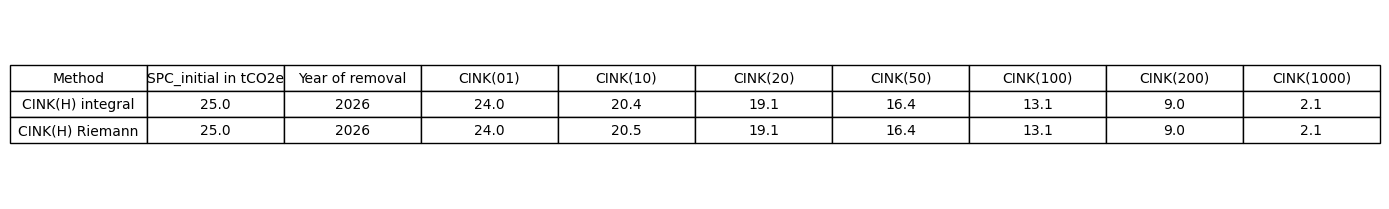

In [1]:
# CINK Calculation # CINK(H) is the average annual C-sink amount
# CINK(H) is the sum of the annual Int_SPC over each years until the end of the time horizon H divided by H to obtain the average annual sink factor.
# CINK(H) can also be calculated as Int from t=0 to H of fSPC(t)dt diveded by 0
# Standards may also accept to use the trapezoide Riemann Sum over the years until H

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- SPC retention parameters (Eq. 11; Schmidt et al., 2025)
a1_spc, k1 = 0.1787, 0.5337
a2_spc, k2 = 0.8237, 0.00997

# Inputs
SPC_initial = 25.0 # is like in GBCS table # 110.8 for 1 t CH4 # change here the amount of SPC you want to calculate
year_of_removal = 2026

Hs = [1, 10, 20, 50, 100, 200, 1000] # CINK(H), add H as you like
labels = [f"CINK({h:02d})" if h < 1000 else "CINK(1000)" for h in Hs]

def f_SPC(t):
    """
    SPC retention curve:
    f_SPC(t) = a1 exp(-k1 t) + a2 exp(-k2 t)
    Works for scalar or vector t.
    """
    t = np.asarray(t, dtype=float)
    return a1_spc*np.exp(-k1*t) + a2_spc*np.exp(-k2*t)

def SPC_int_analytic(H):
    """Analytic integral: ∫_0^H f_SPC(t) dt"""
    H = float(H)
    return (
        a1_spc*(1.0 - np.exp(-k1*H))/k1 +
        a2_spc*(1.0 - np.exp(-k2*H))/k2
    )

# --- Helper: annual Int_SPC for each year i (integral from i-1 .. i)
def annual_Int_SPC(i, use_numeric=False, n=None):
    if i <= 0:
        return 0.0
    else:
        return SPC_int_analytic(i) - SPC_int_analytic(i-1)

# --- Trapezoid approximation of integral from 0..H using yearly f_SPC samples
def CINK_trapezoid(H):
    # H must be integer here
    t = np.arange(0, H + 1, 1, dtype=float)  # 0,1,...,H
    f = f_SPC(t)  # fSPC at integer years
    integral_approx = np.sum(0.5 * (f[:-1] + f[1:]) * 1.0)  # dt=1 year
    return integral_approx / H  # average annual factor



# --- Compute values: analytic (your annual integrals) and trapezoid (sampling f_SPC)
vals_analytic = []
vals_trap = []

for h in Hs:
    # Analytic/annual-integral version
    CINK_h = SPC_int_analytic(h) / h
    vals_analytic.append(CINK_h * SPC_initial)

    # Trapezoid version
    CINK_h_trap = CINK_trapezoid(h)
    vals_trap.append(CINK_h_trap * SPC_initial)

# --- Build 2-row DataFrame
df = pd.DataFrame([
    ["CINK(H) integral", SPC_initial, year_of_removal, *vals_analytic],
    ["CINK(H) Riemann", SPC_initial, year_of_removal, *vals_trap]
], columns=["Method", "SPC_initial in tCO2e", "Year of removal", *labels])

# --- Prepare formatted cell text ONLY for plotting (1 decimal)
cell_text = df.copy()
for c in labels:
    cell_text[c] = cell_text[c].map(lambda x: f"{x:.1f}")

cell_text["SPC_initial in tCO2e"] = cell_text["SPC_initial in tCO2e"].map(lambda x: f"{x:.1f}")
cell_text["Year of removal"] = cell_text["Year of removal"].astype(int).astype(str)

# --- Render as Matplotlib table
fig, ax = plt.subplots(figsize=(14, 2.2))
ax.axis("off")

fig.patch.set_facecolor("white")
ax.set_facecolor("white")

tbl = ax.table(
    cellText=cell_text.values,
    colLabels=cell_text.columns,
    cellLoc="center",
    loc="center"
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.4)

# Force readable colors
for (row, col), cell in tbl.get_celld().items():
    cell.set_facecolor("white")
    cell.set_text_props(color="black")
    cell.set_edgecolor("black")

plt.tight_layout()
os.makedirs("../figures", exist_ok=True)
# remove # to save the table as jpg, check the path
# plt.savefig("../figures/CINK_table_int_vs_Riem.jpg", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

## SPC–Methane Offsetting Tool (TCE/IRF framework)

The goal is to determine the mass of SPC (in tCO$_2$e at $t=0$) required to offset a given methane emission $M_{\mathrm{CH4}}$ over a specified SPC delivery horizon $H$, using the **Time-integrated Climate Effect (TCE)** framework.

## CO$_2$ impulse response function (IRF)

The atmospheric decay of a CO$_2$ pulse is represented by a multi-exponential impulse response function (Jeltsch-Thömmes, A., Joos, F., 2019. *The response to pulse-like perturbations in atmospheric carbon and carbon isotopes* 1–36.):

$$
\mathrm{IRF}(t)
= a_0 + \sum_{j=1}^{5} a_j \, e^{-t/\tau_j}
$$

with:

$$
a_0 = 0.008,\quad
(a_1,\dots,a_5)=(0.044,\;0.112,\;0.224,\;0.310,\;0.297)
$$

$$
(\tau_1,\dots,\tau_5)=(68521,\;5312,\;362,\;47,\;6)\ \text{yr}
$$

The analytic time-integral of the IRF over a horizon $T$ is:

$$
\int_{0}^{T} \mathrm{IRF}(t)\,\mathrm{d}t
= a_0\,T + \sum_{j=1}^{5} a_j \tau_j \left(1-e^{-T/\tau_j}\right)
$$

## TCE of methane emissions

Methane emissions are expressed as CO$_2$-equivalent pulse emissions using $\mathrm{GWP}_{100}$.
The time-integrated climate effect of a methane emission $M_{\mathrm{CH4}}$ over the reference horizon of 100 years is:

$$
\mathrm{TCE}_{\mathrm{CH4}}(100)
= M_{\mathrm{CH4}}\cdot \mathrm{GWP}_{100}\cdot \int_{0}^{100} \mathrm{IRF}(t)\,\mathrm{d}t
$$

The unit of TCE is $\mathrm{tCO_2e \cdot yr}$.

## TCE of an SPC sink over a horizon $H$

The retention of the sink is described by the SPC function $f_{\mathrm{SPC}}(t)$.
To compute the time-integrated climate effect of a non-permanent sink, the sink must be weighted by the CO$_2$ IRF. This yields the kernel:

$$
y(t)=f_{\mathrm{SPC}}(t)\cdot \mathrm{IRF}(t)
$$

Its integral defines:

$$
I(H)=\int_{0}^{H} f_{\mathrm{SPC}}(t)\cdot \mathrm{IRF}(t)\,\mathrm{d}t
$$

For an SPC sink of initial magnitude $M_{\mathrm{SPC}}$ (in tCO$_2$e), the corresponding TCE is:

$$
\mathrm{TCE}_{\mathrm{SPC}}(H) = -\,M_{\mathrm{SPC}} \cdot I(H)
$$

## Offset condition and required SPC mass

Offsetting is achieved when the positive methane TCE is exactly compensated by the negative SPC sink TCE:

$$
\mathrm{TCE}_{\mathrm{CH4}}(100) + \mathrm{TCE}_{\mathrm{SPC}}(H)=0
$$

Solving for the required SPC mass yields:

$$
M_{\mathrm{SPC,req}}(H)
= \frac{\mathrm{TCE}_{\mathrm{CH4}}(100)}{I(H)}
$$

## Reporting the corresponding CINK(H)

Once $M_{\mathrm{SPC,req}}$ is known, its corresponding average annual sink amount over the horizon $H$ can be reported using the CINK definition from Cell 1:

$$
\mathrm{CINK}(H)_{\mathrm{SPC}}
= M_{\mathrm{SPC,req}}(H)\cdot \frac{1}{H}\int_{0}^{H} f_{\mathrm{SPC}}(t)\,\mathrm{d}t
$$

**Note:** The methane climate effect is evaluated over a fixed **100-year** reference horizon because $\mathrm{GWP}_{100}$ is used, whereas the sink horizon $H$ is the crediting horizon and user-selected (e.g. $H=20$ years). It represents the time period over which the SPC sink is delivered and credited.


In [2]:
# SPC – Methane Offsetting Tool (TCE / IRF framework)

# -------------------------
# USER INPUTS
# -------------------------
CH4_offset = 1.0         # How much methane do you want to offset
GWP_100 = 25.0            # natural: 27.0, fossil: 29.2, mixed: 27.9
H = 20                    # offset horizon for the sink (years)

# Requires: f_SPC(t) and SPC_int_analytic(H) from Cell 1

# -------------------------
# CO2 IRF parameters (Jeltsch-Thömmes & Joos, 2019; as used in your notebooks)
# -------------------------
a0 = 0.008
a  = np.array([0.044, 0.112, 0.224, 0.310, 0.297], dtype=float)
tau = np.array([68521, 5312, 362, 47, 6], dtype=float)  # years

def IRF(t):
    """
    CO2 impulse response function (IRF).
    IRF(t) = a0 + Σ a_i * exp(-t/tau_i)
    Works for scalar or vector t.
    """
    t = np.asarray(t, dtype=float)
    return a0 + np.sum(a[:, None] * np.exp(-t[None, :] / tau[:, None]), axis=0) if t.ndim == 1 else (
        a0 + np.sum(a * np.exp(-t / tau))
    )

def IRF_int(H):
    """
    Analytic integral of IRF from 0..H:
    ∫0^H IRF(t) dt = a0*H + Σ a_i * tau_i * (1 - exp(-H/tau_i))
    """
    H = float(H)
    return a0 * H + np.sum(a * tau * (1.0 - np.exp(-H / tau)))

def I_analytic(H):
    """
    Analytic integral of kernel:
    I(H) = ∫0^H f_SPC(t) * IRF(t) dt

    With f_SPC(t) = a1_spc exp(-k1 t) + a2_spc exp(-k2 t)
    and IRF(t) = a0 + Σ a_i exp(-t/tau_i)

    The integral has a closed form as a sum of exponentials:
    ∫ exp(-k t) dt = (1 - exp(-kH))/k
    ∫ exp(-(k + 1/tau) t) dt = (1 - exp(-(k + 1/tau)H)) / (k + 1/tau)
    """
    H = float(H)

    # Use SPC parameters from Cell 1 (a1_spc, k1, a2_spc, k2 must exist)
    spc_terms = [(a1_spc, k1), (a2_spc, k2)]

    total = 0.0
    for A_spc, k_spc in spc_terms:
        # Contribution from a0 term
        total += A_spc * a0 * (1.0 - np.exp(-k_spc * H)) / k_spc

        # Contributions from exponential IRF terms
        total += np.sum(
            A_spc * a * (1.0 - np.exp(-(k_spc + 1.0/tau) * H)) / (k_spc + 1.0/tau)
        )

    return total  # units: years

# -------------------------
# TCE calculation
# -------------------------
# Methane TCE over 100-year reference horizon (as in your notebook/paper)
IRFint100 = IRF_int(100)                                     # yr
TCE_methane_100 = CH4_offset * GWP_100 * IRFint100           # tCO2e·yr

# SPC TCE kernel integral over the sink horizon H
I_H = I_analytic(H)                                     # yr

# Required SPC mass at t=0 (in tCO2e)
M_SPC_required = TCE_methane_100 / I_H

# Check: SPC TCE should be -TCE_methane_100
TCE_SPC_H = -M_SPC_required * I_H

# Corresponding CINK(H_sink) for that SPC pool
CINK_factor = SPC_int_analytic(H) / H              # dimensionless
CINK_H_value = CINK_factor * M_SPC_required                  # tCO2e/yr

# -------------------------
# PRINT RESULTS
# -------------------------
print("\nSPC – Methane Offsetting Tool (TCE/IRF framework)")
print("-------------------------------------------------------------")
print(f"(1) CH4 to offset:                          {CH4_offset:.4f} t CH4")
print(f"(2) TCE_methane(100):                       {TCE_methane_100:,.2f} tCO2e·yr")
print(f"(3) Required SPC mass at t=0 (H={H}):  {M_SPC_required:,.2f} tCO2e")
print(f"(4) TCE_SPC({H}) check:                {TCE_SPC_H:,.2f} tCO2e·yr")
print(f"(5) Corresponding CINK({H}):           {CINK_H_value:,.2f} tCO2e/yr")
print("-------------------------------------------------------------")
print(f"Sanity: TCE_methane(100) + TCE_SPC({H}) = {(TCE_methane_100 + TCE_SPC_H):.4e} tCO2e·yr")




SPC – Methane Offsetting Tool (TCE/IRF framework)
-------------------------------------------------------------
(1) CH4 to offset:                          1.0000 t CH4
(2) TCE_methane(100):                       1,262.02 tCO2e·yr
(3) Required SPC mass at t=0 (H=20):  113.17 tCO2e
(4) TCE_SPC(20) check:                -1,262.02 tCO2e·yr
(5) Corresponding CINK(20):           86.41 tCO2e/yr
-------------------------------------------------------------
Sanity: TCE_methane(100) + TCE_SPC(20) = 0.0000e+00 tCO2e·yr


## Rationale for updating the CSI methane offset methodology (Jan 2026)

For comparability with the former EasyCert methane compensation calculator, this notebook provides an optional *legacy mode* that uses $\mathrm{GWP}_{100}=25$ and a 1-year left Riemann sum approximation of the CO$_2$ IRF integral, as was done in the CSI Methane Calculator until Jan 2026. However, the newly adopted method provides (i) a flexible $\mathrm{GWP}_{100}$ aligned with AR6 values for natural, mixed, and fossil methane, and (ii) continuous-time integration (analytic integral or equivalent high-accuracy numerical integration). This update is justified for the following reasons.

### 1) Alignment with current scientific consensus (AR6 methane metrics)

The choice of $\mathrm{GWP}_{100}=25$ in the former CSI calculator corresponded to an older IPCC assessment (AR4) and is no longer the recommended value for methane under current scientific consensus. AR6 differentiates methane according to source type because fossil methane introduces additional carbon to the atmosphere whereas biogenic methane largely recycles carbon already in the biosphere. Using source-specific AR6-consistent $\mathrm{GWP}_{100}$ values (natural, mixed, fossil) improves scientific accuracy and policy relevance, and avoids systematic under- or over-crediting of offset requirements for specific methane sources. It also makes the method compatible with the evolving standards landscape, which increasingly demands explicit source attribution and transparent assumptions.

### 2) Consistency with the definition of TCE as a time integral

The Time-integrated Climate Effect (TCE) is fundamentally defined as an integral in continuous time. Both the CO$_2$ impulse response function $\mathrm{IRF}(t)$ and the SPC retention function $f_{\mathrm{SPC}}(t)$ are continuous functions. Consequently, the physically consistent expression for the methane warming effect is:

$$
\mathrm{TCE}_{\mathrm{CH4}}(100)=M_{\mathrm{CH4}}\cdot \mathrm{GWP}_{100}\cdot \int_{0}^{100} \mathrm{IRF}(t)\,\mathrm{d}t
$$

and the climate effect of the SPC sink is:

$$
\mathrm{TCE}_{\mathrm{SPC}}(H)=-M_{\mathrm{SPC}}\cdot \int_{0}^{H} f_{\mathrm{SPC}}(t)\,\mathrm{IRF}(t)\,\mathrm{d}t
$$

Using the time integral therefore implements exactly the quantity defined by the underlying theory, rather than an approximation.

### 3) Avoidance of discretization artefacts from annual-step Riemann sums

Splitting the time horizon into annual intervals does not change the result if each interval is integrated exactly. The difference arises when the annual integrals are approximated by *rectangles* (constant value over the year) rather than by the arithmetic integral of the continuous function. In the former CSI implementation, the CO$_2$ IRF integral (and analogously the sink kernel integral) was approximated using a 1-year **left Riemann sum**:

$$
\int_{0}^{H} f(t)\,\mathrm{d}t
\;\approx\;
\sum_{k=0}^{H-1} f(k)\cdot \Delta t,
\qquad \Delta t = 1~\text{yr}.
$$

Because $\mathrm{IRF}(t)$ and the sink-weighted kernel change strongly nonlinearly within the first years, this annual-step rectangle approximation introduces method-dependent deviations. Using the analytic integral (or high-accuracy numerical integration) removes these discretization artefacts and yields stable, resolution-independent results.

### 4) Improved internal consistency of the offset condition

Offsetting is defined by equality of the integrated climate effects:

$$
\mathrm{TCE}_{\mathrm{CH4}}(100) + \mathrm{TCE}_{\mathrm{SPC}}(H)=0
$$

When both terms are computed using the same integral-based framework, the required SPC mass

$$
M_{\mathrm{SPC,req}}(H)=\frac{\mathrm{TCE}_{\mathrm{CH4}}(100)}{\int_{0}^{H} f_{\mathrm{SPC}}(t)\,\mathrm{IRF}(t)\,\mathrm{d}t}
$$

is determined by physically meaningful quantities only. This ensures that offset requirements depend on methane source attribution, the chosen sink horizon $H$, and the scientifically defined IRF and retention curve – rather than on a discretization convention.

### 5) Transparency, auditability, and forward compatibility

The updated method is transparent (all parameters and integrals are explicitly defined), auditable (analytic expressions can be verified), and forward compatible (future changes in methane metrics or IRF parameterizations can be incorporated without altering the conceptual framework). At the same time, the legacy mode remains available for benchmarking and historical comparability, making the transition traceable and defensible.

In summary, moving from the former CSI implementation ($\mathrm{GWP}_{100}=25$ with annual left Riemann sums) to flexible AR6-consistent methane metrics and continuous-time integration is the scientifically and methodologically correct choice. It improves accuracy, removes avoidable numerical artefacts, aligns with current guidance, and strengthens the robustness of methane offset quantification.


In [11]:
# For comparability with the former EasyCert methane compensation calculator, we provide here an optional legacy mode that uses GWP100 = 25 and a 1-year left Riemann sum approximation of the CO₂ IRF integral as was done in the CSI Methane Calculator until Jan 2026

import numpy as np
import pandas as pd

# -------------------------
# USER INPUTS
# -------------------------
CH4_offset = 1.0
GWP_100 = 25.0
H_sink = 20
T_ref = 100

# -------------------------
# Discrete approximations (Δt = 1 year)
# -------------------------

def riemann_left(func, T):
    """∫0^T f(t) dt ≈ Σ_{k=0..T-1} f(k) * 1"""
    k = np.arange(0, int(T), 1, dtype=float)
    return np.sum(func(k))

def riemann_right(func, T):
    """∫0^T f(t) dt ≈ Σ_{k=1..T} f(k) * 1"""
    k = np.arange(1, int(T)+1, 1, dtype=float)
    return np.sum(func(k))

def trapezoid_year(func, T):
    """∫0^T f(t) dt ≈ Σ_{k=0..T-1} 0.5*(f(k)+f(k+1)) * 1"""
    k = np.arange(0, int(T)+1, 1, dtype=float)
    y = func(k)
    return np.sum(0.5 * (y[:-1] + y[1:]))

# Kernel integrals: f_SPC(t) * IRF(t)
def kernel(t):
    return f_SPC(t) * IRF(t)

# -------------------------
# Compute IRF integrals over 100 years
# -------------------------
IRF_analytic = IRF_int(T_ref)
IRF_left     = riemann_left(IRF, T_ref)
IRF_right    = riemann_right(IRF, T_ref)
IRF_trap     = trapezoid_year(IRF, T_ref)

# -------------------------
# Compute kernel integrals I(H) over sink horizon
# -------------------------
I_ana  = I_analytic(H_sink)
I_left = riemann_left(kernel, H_sink)
I_right= riemann_right(kernel, H_sink)
I_trap = trapezoid_year(kernel, H_sink)

# -------------------------
# Methane TCE over 100 years
# -------------------------
TCE_CH4_ana   = CH4_offset * GWP_100 * IRF_analytic
TCE_CH4_left  = CH4_offset * GWP_100 * IRF_left
TCE_CH4_right = CH4_offset * GWP_100 * IRF_right
TCE_CH4_trap  = CH4_offset * GWP_100 * IRF_trap

# -------------------------
# Required SPC mass for offset
# -------------------------
M_req_ana   = TCE_CH4_ana   / I_ana
M_req_left  = TCE_CH4_left  / I_left
M_req_right = TCE_CH4_right / I_right
M_req_trap  = TCE_CH4_trap  / I_trap

# -------------------------
# Helper: percent deviation from analytic
# -------------------------
def pct_dev(x, x_ref):
    return 100.0 * (x - x_ref) / x_ref

# -------------------------
# Collect results in a table
# -------------------------
methods = ["Analytic", "Left Riemann, the former CSI-method", "Right Riemann", "Trapezoid"]

df = pd.DataFrame({
    "Method": methods,
    "IRF_int(100) [yr]": [IRF_analytic, IRF_left, IRF_right, IRF_trap],
    f"I({H_sink}) [yr]": [I_ana, I_left, I_right, I_trap],
    "TCE_CH4(100) [tCO2e·yr]": [TCE_CH4_ana, TCE_CH4_left, TCE_CH4_right, TCE_CH4_trap],
    "M_SPC_required [tCO2e]": [M_req_ana, M_req_left, M_req_right, M_req_trap],
})

# Add deviations
df["Δ IRF_int vs analytic [%]"] = df["IRF_int(100) [yr]"].apply(lambda x: pct_dev(x, IRF_analytic))
df[f"Δ I({H_sink}) vs analytic [%]"] = df[f"I({H_sink}) [yr]"].apply(lambda x: pct_dev(x, I_ana))
df["Δ M_required vs analytic [%]"] = df["M_SPC_required [tCO2e]"].apply(lambda x: pct_dev(x, M_req_ana))

# Format display
df_narrow = df.copy()
df_narrow = df_narrow[[
    "Method",
    "IRF_int(100) [yr]",
    f"I({H_sink}) [yr]",
    "TCE_CH4(100) [tCO2e·yr]",
    "M_SPC_required [tCO2e]"
]]
df_narrow.columns = pd.MultiIndex.from_tuples([
    ("", "Method"),
    ("Integrals", "IRF_int(100) [yr]"),
    ("Integrals", f"I({H_sink}) [yr]"),
    ("TCE", "TCE_CH4(100) [tCO2e·yr]"),
    ("Required SPC", "M_SPC_required [tCO2e]")
])
# round to make it narrower
df_narrow = df_narrow.copy()
for col in df_narrow.columns:
    if col[1] != "Method":
        df_narrow[col] = df_narrow[col].astype(float).round(4)

display(df_narrow)


Integrals             \
                                Method IRF_int(100) [yr] I(20) [yr]   
0                             Analytic           50.4808    11.1512   
1  Left Riemann, the former CSI-method           50.7986    11.4639   
2                        Right Riemann           50.1723    10.8637   
3                            Trapezoid           50.4855    11.1638   

                      TCE           Required SPC  
  TCE_CH4(100) [tCO2e·yr] M_SPC_required [tCO2e]  
0               1262.0211               113.1732  
1               1269.9653               110.7797  
2               1254.3079               115.4583  
3               1262.1366               113.0561